In [1]:
import EEG_Decoder.eeg_decoder as eeg_decoder
import numpy as np
import pandas as pd
from collections import OrderedDict
from utils import clean_behavior
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none' # change svg font type from path to text
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(2023)

OVERWRITE = False

In [3]:
experiment_name = 'DATA/Preprocessed'
data_dir = f'../../{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False, trim_timepoints=[-250, 1250])
exp.behavior_files

In [4]:
exp.behavior_files = sorted(list(exp.data_dir.glob('*.csv')))

In [5]:
time_window = 25
time_step = 25
trial_bin_size = 20
n_splits = 1000
group_dict = OrderedDict([('Set size 1',[11, 13]),('Set size 2',[21, 22, 23])])

wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [6]:
if OVERWRITE:
    sub_nDots = {'SS1': [], 'SS2': []}
    for isub in range(exp.nsub):
        print(isub)
        
        xdata, ydata = exp.load_eeg(isub)
        
        # get info about nDots ranges
        noArt_idx = exp.load_artifact_idx(isub)
        assert xdata.shape[0]==noArt_idx.sum()
        
        behavior = pd.read_csv(exp.behavior_files[isub])

        behavior = clean_behavior(behavior, noArt_idx, isub)    
        assert len(behavior)==xdata.shape[0]
        
        # drop interruption trials for subs 4,5
        no_interruption_trials = (behavior.port_codes < 240).values
        behavior = behavior[no_interruption_trials].reset_index(drop=True)
        xdata = xdata[no_interruption_trials, :, :]
        
        sub_nDots['SS1'].append(behavior.query('total_nDots >= 24').query('SetSize==1').total_nDots.mean())
        sub_nDots['SS2'].append(behavior.query('total_nDots >= 24').query('SetSize==2').total_nDots.mean())
        
        # subset to match nDots range
        matched_dots_idx = behavior.query('total_nDots >= 24').index.values
        xdata = xdata[matched_dots_idx, :, :]
        ydata = ydata[matched_dots_idx]
        
        xdata,ydata = wrangl.group_labels(xdata,ydata)
        for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):
            X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test) 
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

    # save results
    interp = eeg_decoder.Interpreter(clfr, subtitle='1vs2')
    interp.save_results(timestamp=False)

    nDots_df = pd.DataFrame(sub_nDots)
    nDots_df.to_csv(f'{interp.output_dir}/nDots.csv', index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [7]:
interp = eeg_decoder.Interpreter()
interp.load_results('1vs2')
# interp.save_results()

Significant timepoints: [  86  110  134  158  182  206  230  254  278  302  326  350  374  398
  422  446  470  494  518  542  566  590  614  638  662  686  710  734
  758  782  806  830  854  878  902  926  950  974  998 1022 1046 1070
 1094 1118 1142 1166 1190 1214]
Mean delay accuracy: 0.6822203782255214
Mean delay S.D.: 0.056099922745901136


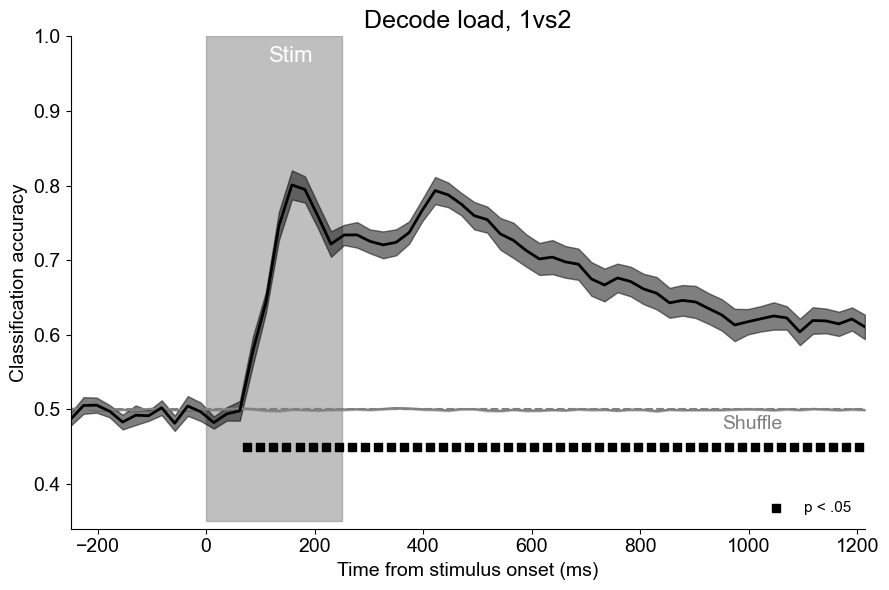

In [8]:
interp.plot_acc(significance_testing=True,savefig=False,ylim=[.34,1],chance_text_y=.23, title='Decode load, 1vs2')
plt.tight_layout()
plt.savefig('RawFigures/decode_load.svg')

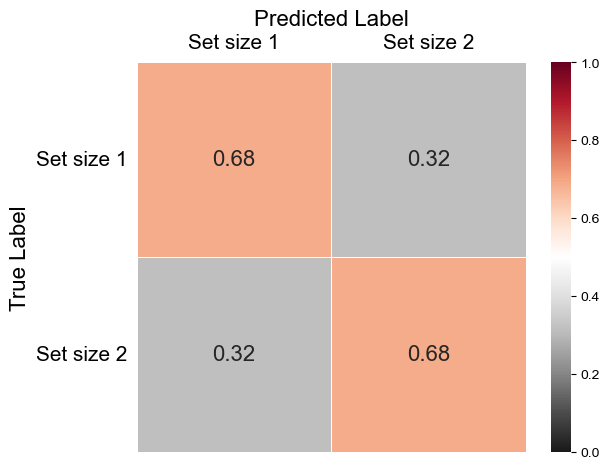

In [9]:
interp.plot_confusion_matrix()
plt.tight_layout()
plt.savefig('RawFigures/decode_load_confusion_matrix.svg')

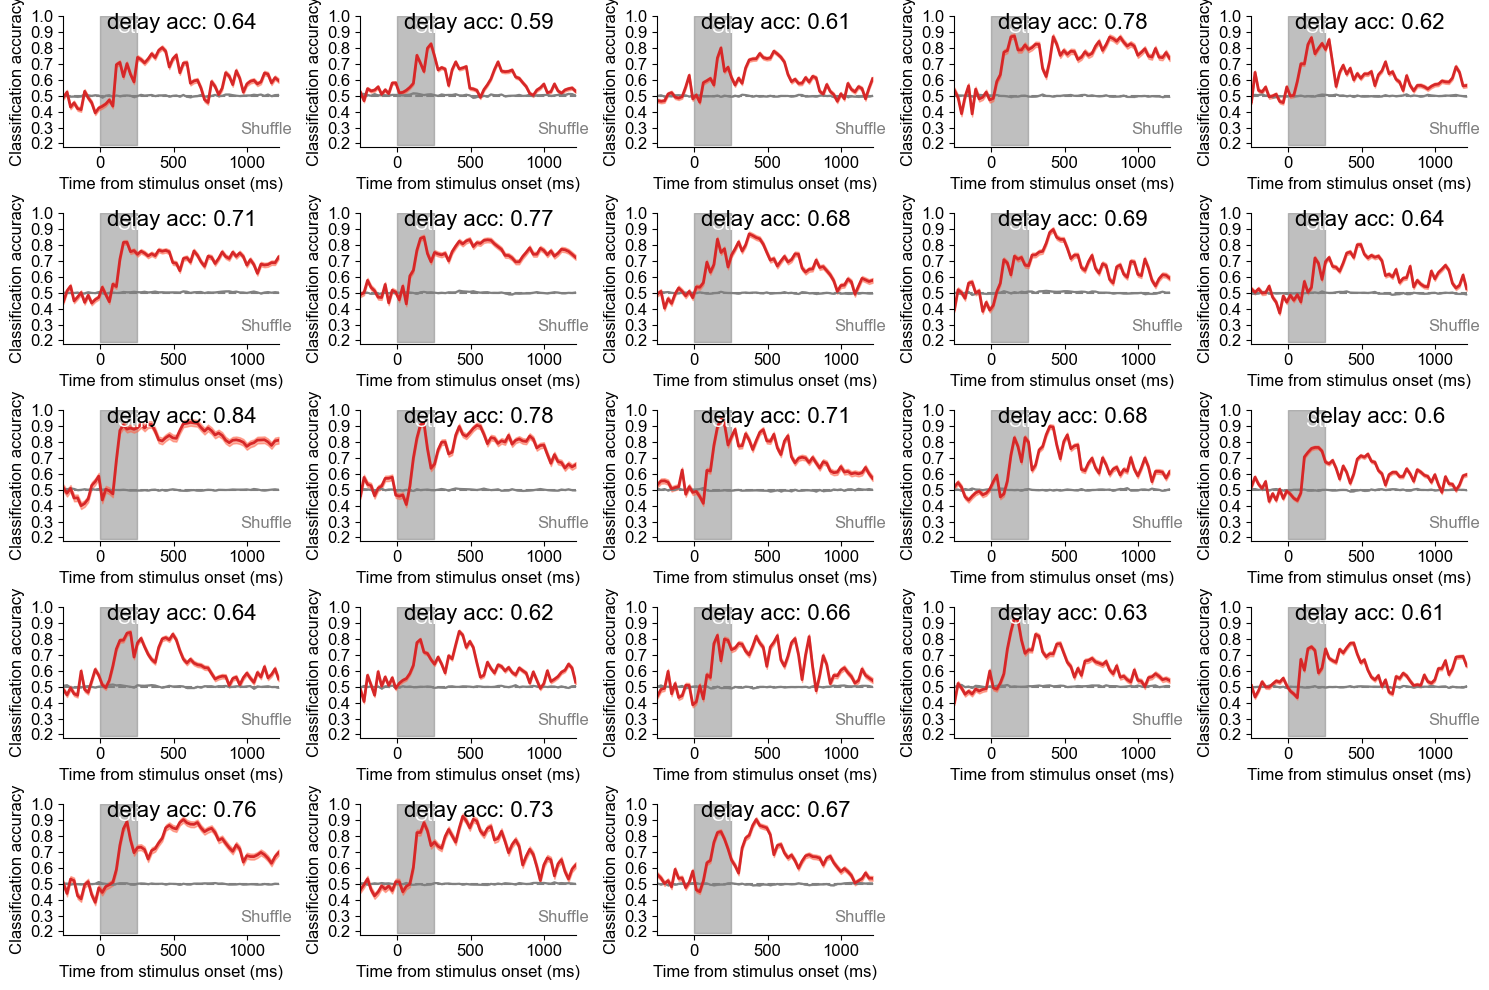

In [10]:
interp.plot_acc_by_subject(subplot_dims=(5,5))
plt.tight_layout()
plt.savefig('Figures/decode_load_individual_acc.png')

## bayes factors

In [11]:
import pingouin as pg

import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

In [12]:
# Bayes Factors
# this is code modified from eeg_decoder.Interpreter.plot_acc
acc = np.mean(interp.acc, 2)
acc_shuff = np.mean(interp.acc_shuff, 2)

bfs = np.zeros(len(interp.t[interp.t > 0]))

# # only test on timepoints after stimulus onset
for i, t in enumerate(np.arange(len(interp.t))[interp.t > 0]):
#     # one-sided paired ttest
    t_res = pg.ttest(x=acc[:, t], y=acc_shuff[:, t], paired=True, alternative='greater')
    bfs[i] = float(t_res.loc['T-test', 'BF10'])
#     _, p[i] = sista.ttest_rel(
#         a=acc[:, t], b=acc_shuff[:, t], alternative='greater')

# convert evidence for null to negative values of same magnitude
# do the same for log values
null_bfs = bfs < 1
bfs[null_bfs] = 1 / bfs[null_bfs]
log_bfs = np.log10(bfs)
log_bfs[null_bfs] = -log_bfs[null_bfs]

bfs[null_bfs] = -bfs[null_bfs]  

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


<Axes: >

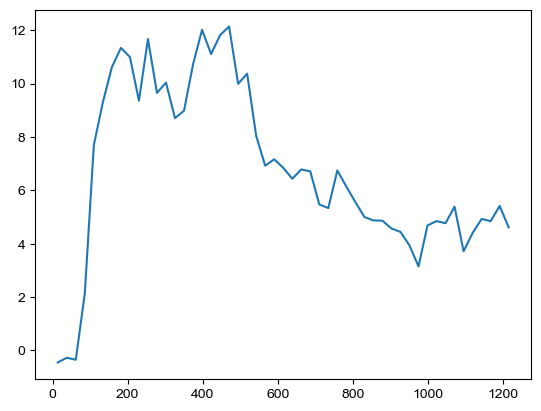

In [13]:
import seaborn as sns
sns.lineplot(x=interp.t[interp.t > 0], y=log_bfs)

## Remove participants with informative eye movements (delay acc > 60%)

In [14]:
bad_eyes = pd.read_csv('informative_eye_subs.csv', index_col=0).index.values

interp = eeg_decoder.Interpreter()
interp.load_results('1vs2')

interp.acc = np.delete(interp.acc, bad_eyes, axis=0)
interp.acc_shuff = np.delete(interp.acc_shuff, bad_eyes, axis=0)
interp.conf_mat = np.delete(interp.conf_mat, bad_eyes, axis=0)

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Significant timepoints: [  86  110  134  158  182  206  230  254  278  302  326  350  374  398
  422  446  470  494  518  542  566  590  614  638  662  686  710  734
  758  782  806  830  854  878  902  926  950  974  998 1022 1046 1070
 1094 1118 1142 1166 1190 1214]
Mean delay accuracy: 0.6713497432605905
Mean delay S.D.: 0.061230737897061245


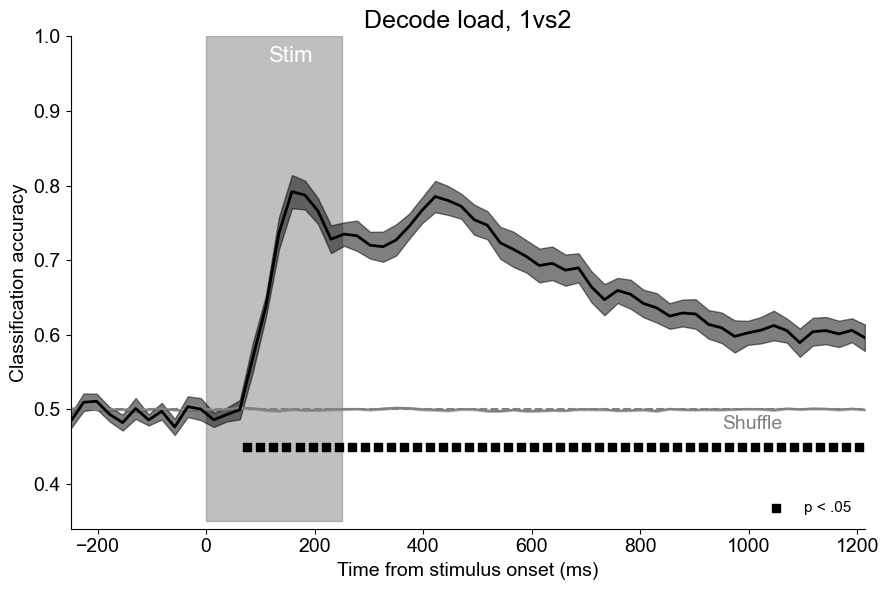

In [15]:
# interp = eeg_decoder.Interpreter(clfr, subtitle='1vs2')
interp.plot_acc(significance_testing=True,savefig=False,ylim=[.34,1],chance_text_y=.23, title='Decode load, 1vs2')
plt.tight_layout()
plt.savefig('RawFigures/decode_load_noInformativeEyes.svg')

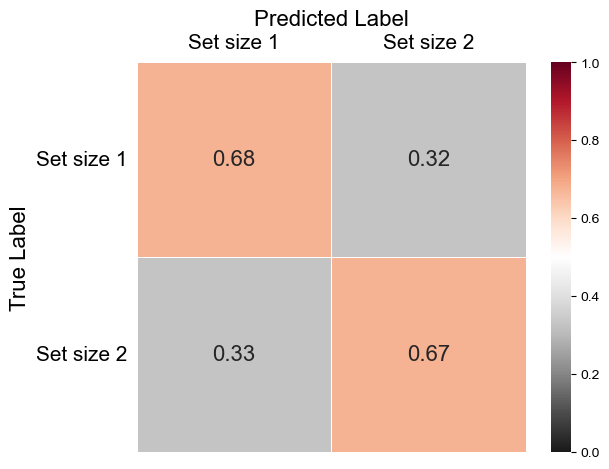

In [16]:
interp.plot_confusion_matrix()
plt.tight_layout()
plt.savefig('RawFigures/decode_load_confusion_matrix_noInformativeEyes.svg')

## Checking distribution of the mean number of dots across the two set sizes, after filtering

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

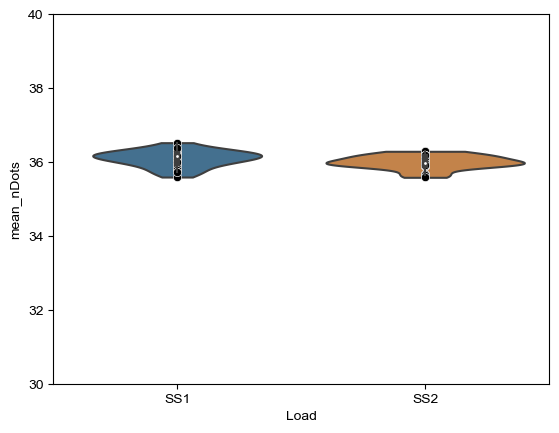

In [18]:
# nDots_df = pd.DataFrame(sub_nDots)
nDots_df = pd.read_csv(f'{interp.output_dir}/nDots.csv')
melted_nDots = pd.melt(nDots_df, value_vars=['SS1', 'SS2'], var_name='Load', value_name='mean_nDots')

_ = sns.violinplot(x='Load', y='mean_nDots', data=melted_nDots, cut=0, saturation=.5)
_ = sns.scatterplot(x='Load', y='mean_nDots', data=melted_nDots, color='k')
_ = plt.xlim(-.5, 1.5)
_ = plt.ylim(30, 40)